## `action-geometry` demo

This demo accompanies the manscript "Behaviorally-relevant features of observed actions dominate cortical representational geometry in natural vision" by Han and colleages ([2024](https://doi.org/10.1101/2024.11.26.624178)). To run this notebook, you'll need an installation of Python 3, Jupyter Lab, NumPy, SciPy, Pandas, Matplotlib, and Seaborn.

In this notebook, we replicate one of the core analyses from the manuscript: using representational similarity analysis (RSA) to test different representational models against neural representational geometry. Participants viewed 90 different 2.5-second video clips depicting real-world actions. We first load in nine different model representational dissimilarity matrices (RDMs) capturing behavioral, semantic, and visual features of the actions. Next, we load in neural RDMs from nine regions of interest (ROIs) spanning the action observation network. Finally, we compute Spearman correlations between the model RDMs and the neural RDMs (corresponding to Fig. 4 in the manuscript).

*Authors:* Jane Han, Sam Nastase (2024)

In [1]:
import numpy as np
from scipy.stats import rankdata, spearmanr
from scipy.spatial.distance import squareform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# local paths to the demo data
roi_dir = 'fmri/cv_rdm'
code_dir = 'scripts'
rdm_dir = 'RDMs'

#### Model RDMs
First, we load in nine model RDMs: visual models of (1) motion energy and (2) gaze; semantic models for (3) nonverbs and (4) verbs; behavioral arrangement models of (5) scene, (6) person, and (7) object features of static images; and behavioral arragnment models of (8) sociality and (9) transitivity in the dynamic videos. For visualization, we also reorder the 90 conditions and label them in a particular way. 

In [3]:
rdm_names = ['motion', 'gaze', 'nonverb', 'verb', 'scene',
             'person', 'object', 'sociality', 'transitivity']
rdms = {name: np.load(f'{rdm_dir}/{name}_rdm.npy') for name in rdm_names}

reorder = np.load(f'{code_dir}/reorder_conditions.npy')
labels = np.load(f'{code_dir}/sparse_ordered_labels.npy').astype(str)

Next, we'll visualize an example model RDM with labels. We convert the dissimilarity of the RDM to rank percentiles for plotting. Note that we use `squareform` to toggle between the 90-by-90 square and 4005-long vectorized off-diagonal versions of the RDM. 

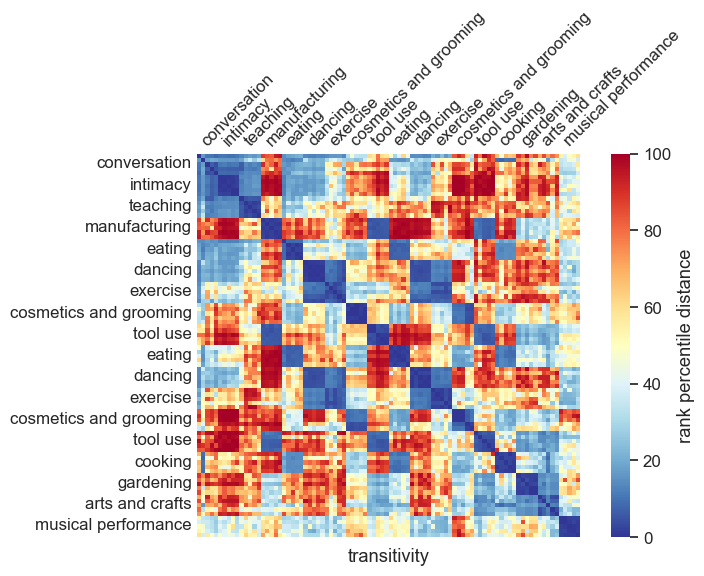

In [4]:
rdm_name = 'transitivity'
rdm = rdms[rdm_name]

sns.set(font_scale=1.1)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(squareform(rankdata(rdm) / len(rdm) * 100)[reorder][:, reorder],
                 vmin=0, vmax=100, square=True, cmap='RdYlBu_r',
                 xticklabels=labels, yticklabels=labels,
                 cbar_kws={'label': 'rank percentile distance'})
ax.xaxis.tick_top()
ax.tick_params(axis='both', which='both', length=0)
plt.xticks(rotation=45, ha='left')
plt.yticks(va='top')
plt.title(rdm_name, va='top', y=-.05)
plt.tight_layout()
plt.show()

Now, we plot all nine model RDMs to see how they compare.

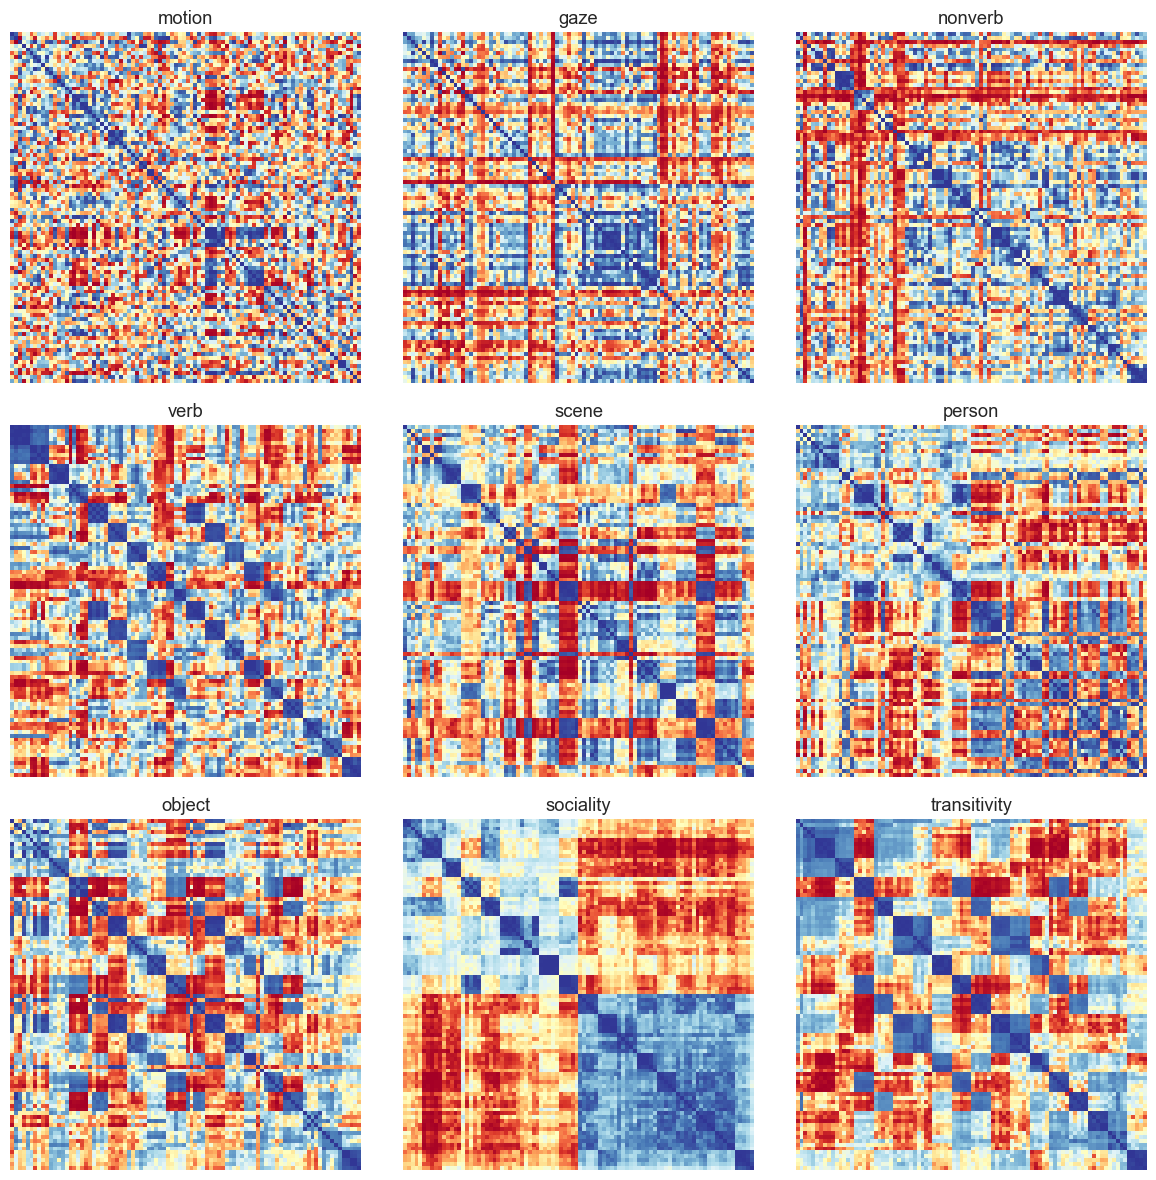

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for rdm_name, ax in zip(rdm_names, axs.ravel()):
    sns.heatmap(squareform(rankdata(rdms[rdm_name]) / len(rdms[rdm_name]) * 100)[reorder][:, reorder],
                vmin=0, vmax=100, square=True, cmap='RdYlBu_r', cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[])
    ax.set_title(rdm_name)
plt.tight_layout()

#### Neural RDMs
In this section, we'll load in neural RDMs computed from patterns of fMRI activity in nine ROIs spanning the visual pathways for action perception. For each ROI, we load in 23 subjects and two hemispheres worth of data.

In [6]:
participants = {'1': 'sid000021', '2': 'sid000120',
                '3': 'sid000005', '4': 'sid000029',
                '5': 'sid000010', '6': 'sid000013',
                '7': 'sid000020', '8': 'sid000024',
                '9': 'sid000009', '10': 'sid000012',
                '11': 'sid000034', '12': 'sid000007',
                '13': 'sid000416', '14': 'sid000433',
                '15': 'sid000134', '16': 'sid000522',
                '17': 'sid000114', '18': 'sid000102',
                '19': 'sid000499', '20': 'sid000142',
                '21': 'sid000535', '22': 'sid000278',
                '23': 'sid000052'}

hemis = ['lh', 'rh']
roi_names = ['EV', 'LO', 'VT', 'pSTS', 'TPJ','PPC', 'AIP', 'VPM', 'PMC']
rois = {}
for roi_name in roi_names:
    rois[roi_name] = {}
    for hemi in hemis:
        rois[roi_name][hemi] = []
        for p in participants:
            rois[roi_name][hemi].append(squareform(
                np.load(f'{roi_dir}/cv_rdm_sub-{participants[p]}_{hemi}_{roi_name}-v2.npy'),
                checks=False))
        rois[roi_name][hemi] = np.vstack(rois[roi_name][hemi])

Let's visualize the neural RDMs for all nine ROIs. For simplicity, we'll only view the left hemisphere ROIs and we'll average the RDMs across subjects.

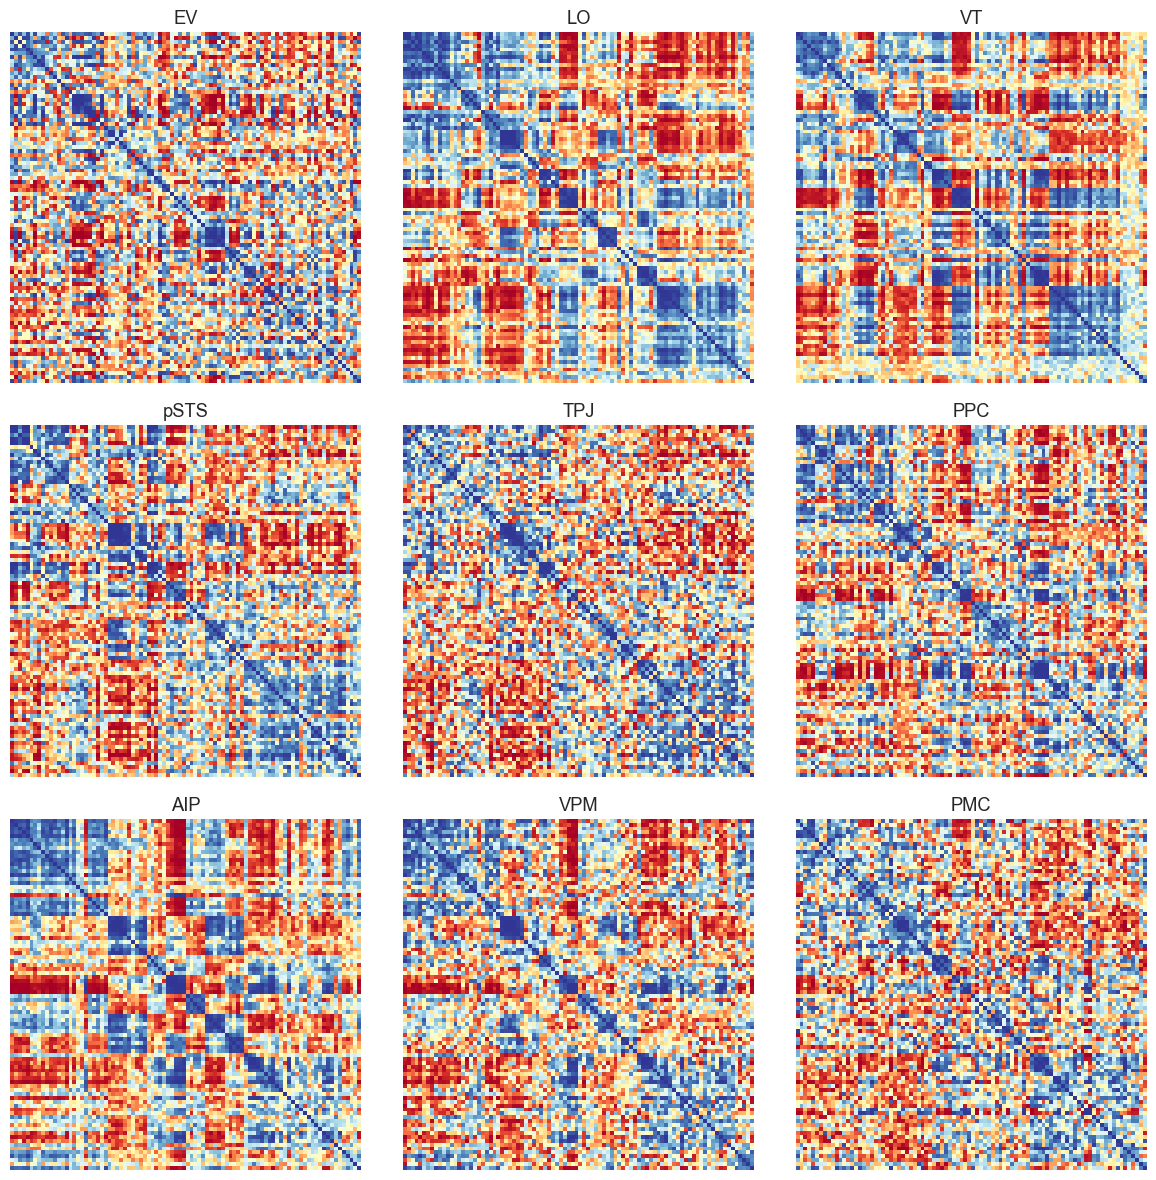

In [7]:
hemi = 'lh'
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for roi_name, ax in zip(roi_names, axs.ravel()):
    sns.heatmap(squareform(rankdata(np.mean(rois[roi_name][hemi], axis=0)) / 
                           len(np.mean(rois[roi_name][hemi], axis=0)) * 100)[reorder][:, reorder],
                vmin=0, vmax=100, square=True, cmap='RdYlBu_r', cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[])
    ax.set_title(roi_name)
plt.tight_layout()

#### Model comparison
Finally, we'll use Spearman correlation to quantify how well each model RDM matches each neural RDM. We compute these correlations within each subject and within each hemisphere, then aggregate the resulting correlation values across subjects.

In [8]:
n_participants = len(participants.keys())
results = {'ROI': [], 'model': [], 'hemisphere': [], 'Spearman r': []}

for roi_name in roi_names:
    for hemi in hemis:
        for rdm_name in rdm_names:
            rs = []
            for p in np.arange(n_participants):
                r = spearmanr(rdms[rdm_name], rois[roi_name][hemi][p])[0]
                rs.append(r)
            results['ROI'].extend([roi_name] * n_participants)
            results['model'].extend([rdm_name] * n_participants)
            results['hemisphere'].extend([hemi] * n_participants)
            results['Spearman r'].extend(rs)
        
results = pd.DataFrame(results)

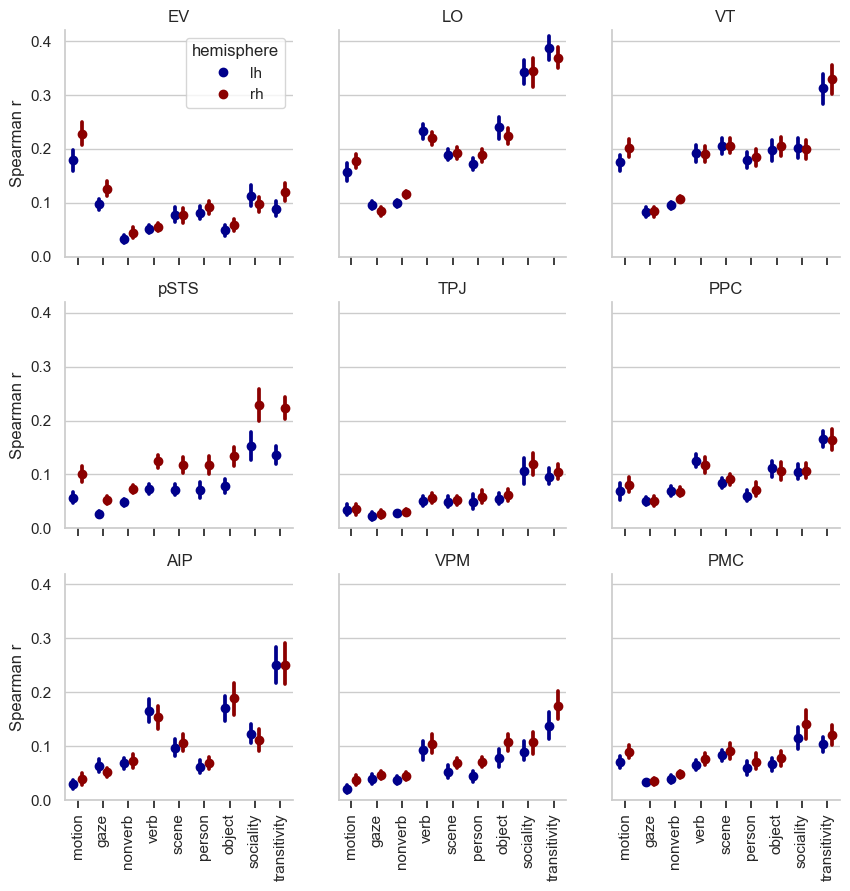

In [9]:
sns.set(style='whitegrid', rc={'xtick.bottom': True})
fig, axs = plt.subplots(3, 3, figsize=(10, 10),
                        sharex=True, sharey=True)
for roi_name, ax in zip(roi_names, axs.ravel()):
    sns.pointplot(x='model', y='Spearman r', hue='hemisphere',
                  data=results[results['ROI'] == roi_name],
                  linestyle='none', markersize=5, ax=ax, dodge=.35,
                  palette=sns.color_palette(['darkblue', 'darkred'], 2))
    ax.set(ylim=(0, .42), title=roi_name, xlabel=None)
    ax.set_xticks(np.arange(len(rdm_names)))
    ax.set_xticklabels(rdm_names, rotation=90)
    if roi_name != 'EV':
        ax.get_legend().remove()
sns.despine()

#### References

* Han, J., Chauhan, V., Philip, R., Taylor, M. K., Jung, H., Halchenko, Y. O., Gobbini, M. I., Haxby, J. V.\* & Nastase, S. A.\* (2024). Behaviorally-relevant features of observed actions dominate cortical representational geometry in natural vision. *bioRxiv*. https://doi.org/10.1101/2024.11.26.624178